# Trabalho de Aprendizagem Automática

## Grupo MMA_AA

##### Bruno Pires, 65377
##### Catarina Pinto, 67114
##### Nuno Costa, 54620 

### TASK 1: Setting the Baseline

#### Task 1.1: Data Preparation and Validation Pipeline

In [54]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.compose import ColumnTransformer
from ftPloty_yhat import plot_y_yhat
#from validatepoli import validate_poly_regression
import seaborn as sns
import time
import math

In [50]:
# Load the data

raw_train_data = pd.read_csv('X_train.csv')
test_data = pd.read_csv('X_test.csv')
new_column_names = {'t':'t', 'x0_1':'x_1', 'y0_1':'y_1', 'x0_2':'x_2', 'y0_2':'y_2', 'x0_3':'x_3','y0_3':'y_3'}
test_data.rename(columns=new_column_names, inplace=True)



2226


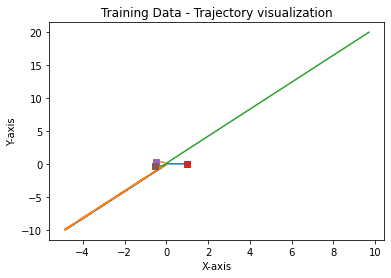

In [5]:
# Exploration of the training data

# Visualization of the trajectories 

idx = np.hstack((0,raw_train_data[raw_train_data.t == 10].index.values +1))

k = np.random.randint(idx.shape[0])
print(k)
pltidx = range(idx[k],257+idx[k])
pltsquare = idx[k]
plt.plot(raw_train_data.x_1[pltidx], raw_train_data.y_1[pltidx])
plt.plot(raw_train_data.x_2[pltidx], raw_train_data.y_2[pltidx])
plt.plot(raw_train_data.x_3[pltidx], raw_train_data.y_3[pltidx]) 

plt.plot(raw_train_data.x_1[pltsquare], raw_train_data.y_1[pltsquare],'s')
plt.plot(raw_train_data.x_2[pltsquare], raw_train_data.y_2[pltsquare],'s')
plt.plot(raw_train_data.x_3[pltsquare], raw_train_data.y_3[pltsquare],'s')   

plt.title('Training Data - Trajectory visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.savefig('TrainData_Trajectory4.png')


In [11]:
# Create the baseline model

# Extract features and targets from the training data

input_features = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
input_features_test = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_variables = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
X = raw_train_data[input_features]
y = raw_train_data[target_variables]
X_test = test_data[input_features_test]
y_test = test_data[target_variables]

#Split the data into 80% training + 20% validation since the test set is given by X_test.csv
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)    



#### TASK 1.2: Learn the baseline model

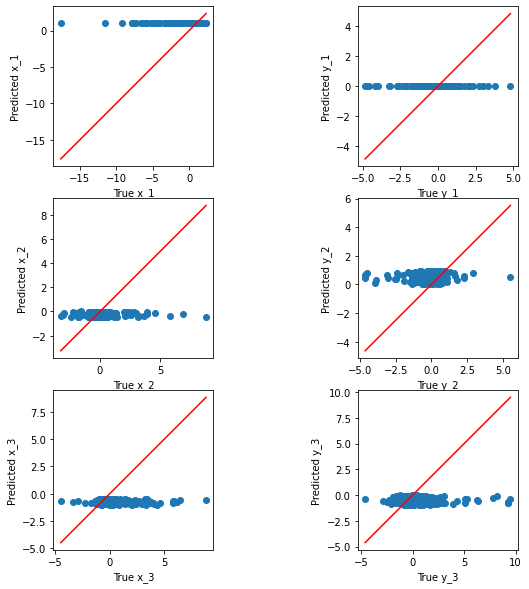

In [12]:
# Create a pipeline with StandardScaler and LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('regressor', LinearRegression())  # Linear Regression model
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the validation and test sets
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train, pipeline.predict(X_train))
train_rmse = np.sqrt(train_mse)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

plot_y_yhat(y_pred_val, y_pred_test, plot_title='Test and validation output')

In [13]:
 print(f"Training MSE: {train_mse}")
 print(f"Training RMSE: {train_rmse}")
 print(f"Validation MSE: {val_mse}")
 print(f"Validation RMSE: {val_rmse}")
 print(f"Test MSE: {test_mse}")
 print(f"Test RMSE: {test_rmse}")

Training MSE: 1.1436198196350285e-26
Training RMSE: 1.0694016175577016e-13
Validation MSE: 1.1216116144768464e-26
Validation RMSE: 1.0590616669849052e-13
Test MSE: 2.047693339502041e-27
Test RMSE: 4.525144571725904e-14


In [15]:
# Getting range of the data to evaluate the RMSE

data_range = X_train['x_1'].max() - X_train['x_1'].min()
print(f"Range of x_1: {data_range}")

data_range2 = X_train['x_2'].max() - X_train['x_2'].min()
print(f"Range of x_2: {data_range2}")

data_range3 = X_train['x_3'].max() - X_train['x_3'].min()
print(f"Range of x_3: {data_range3}")

data_rangey1 = X_train['y_1'].max() - X_train['y_1'].min()
print(f"Range of x_1: {data_rangey1}")

data_rangey2 = X_train['y_2'].max() - X_train['y_2'].min()
print(f"Range of x_2: {data_rangey2}")

data_rangey3 = X_train['y_3'].max() - X_train['y_3'].min()
print(f"Range of x_3: {data_rangey3}")

Range of x_1: 47.05527781701486
Range of x_2: 46.25628027740612
Range of x_3: 79.02131975998066
Range of x_1: 43.88052142955543
Range of x_2: 86.99271748193739
Range of x_3: 60.7738313136513


### TASK 2: Nonlinear models on the data — the Polynomial Regression model
#### TASK 2.1: Development

In [18]:
# Sample the data for 1% to run faster
train_data_sampled = raw_train_data.sample(frac=0.01, replace=True, random_state=1)

# Extract features and targets from the training data
input_features = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_variables = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
X_sample = train_data_sampled[input_features]
y_sample = train_data_sampled[target_variables]


# Split the training + validation set into 80% training and 20% validation
X_train_sampled, X_val_sampled, y_train_sampled, y_val_sampled = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42)




In [25]:
# Evaluate the best degree for the polinomial regression
best_degrees = []
for i in range(10):
    # Optionally shuffle or sample the data differently
    train_data_sampled = raw_train_data.sample(frac=0.01, replace=True, random_state=i)

    X_train_sampled, X_val_sampled, y_train_sampled, y_val_sampled = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=i)
    
    
    # Validate and get the best model for this iteration
    best_pipeline, best_rmse = validate_poly_regression(
        X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, 
        regressor=LinearRegression(), 
        degrees=range(1, 5)
    )

    # Extracting the degree of the polynomial used in the best model
    poly_features = best_pipeline.named_steps['poly_features']
    best_degree = poly_features.degree
    best_degrees.append(best_degree)
    
    print(f"Best degree for iteration {i}: {best_degree}")

Testing degree 1...
Degree 1: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 3...
Degree 3: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 4...
Degree 4: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Best degree for iteration 0: 1
Testing degree 1...
Degree 1: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 3...
Degree 3: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 4...
Degree 4: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Best degree for iteration 1: 1
Testing degree 1...
Degree 1: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.0000
R

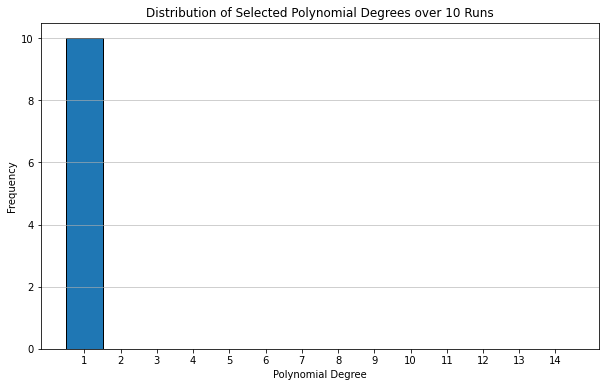

In [26]:

# Plotting the distribution of selected polynomial degrees
plt.figure(figsize=(10, 6))
plt.hist(best_degrees, bins=np.arange(1, 16)-0.5, edgecolor='black', align='mid')
plt.xticks(np.arange(1, 15))
plt.xlabel('Polynomial Degree')
plt.ylabel('Frequency')
plt.title('Distribution of Selected Polynomial Degrees over 10 Runs')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
#### TASK 2.2: Evaluation

Testing degree 1...
Degree 1: Validation RMSE = 0.0001
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.0085
Results saved to polynomial_submission.csv
Testing degree 3...
Degree 3: Validation RMSE = 2.1959
Results saved to polynomial_submission.csv
Testing degree 4...
Degree 4: Validation RMSE = 1365.6144
Results saved to polynomial_submission.csv
Best degree for iteration 0: 1
Testing degree 1...
Degree 1: Validation RMSE = 0.0001
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.0150
Results saved to polynomial_submission.csv
Testing degree 3...
Degree 3: Validation RMSE = 2.3782
Results saved to polynomial_submission.csv
Testing degree 4...
Degree 4: Validation RMSE = 2978.5423
Results saved to polynomial_submission.csv
Best degree for iteration 1: 1
Testing degree 1...
Degree 1: Validation RMSE = 0.0001
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.

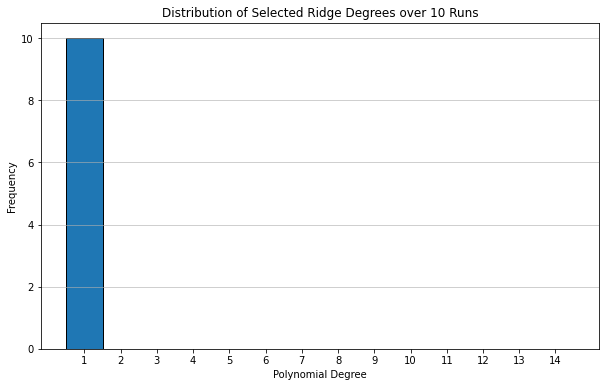

In [27]:

# Call the validation function with RidgeCV

best_degrees = []
for i in range(10):
    ridge_regressor = RidgeCV(alphas=np.logspace(-6, 6, 13)) 
    train_data_sampled = raw_train_data.sample(frac=0.01, replace=True, random_state=i)

    X_train_sampled, X_val_sampled, y_train_sampled, y_val_sampled = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=i)
    
    
    # Validate and get the best model for this iteration
    best_pipeline, best_rmse = validate_poly_regression(
        X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, 
        regressor=ridge_regressor, 
        degrees=range(1, 5)
    )

    # Extracting the degree of the polynomial used in the best model
    poly_features = best_pipeline.named_steps['poly_features']
    best_degree = poly_features.degree
    best_degrees.append(best_degree)
    
    print(f"Best degree for iteration {i}: {best_degree}")
    


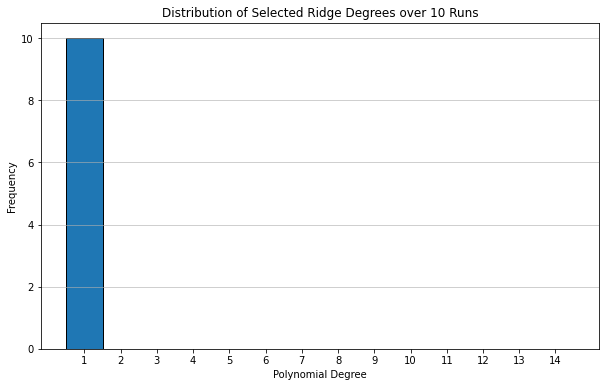

In [28]:
# Plotting the distribution of selected polynomial degrees
plt.figure(figsize=(10, 6))
plt.hist(best_degrees, bins=np.arange(1, 16)-0.5, edgecolor='black', align='mid')
plt.xticks(np.arange(1, 15))
plt.xlabel('Polynomial Degree')
plt.ylabel('Frequency')
plt.title('Distribution of Selected Ridge Degrees over 10 Runs')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [33]:
# Call the validation function with LassoCV 


best_degrees = []
for i in range(10):
    lasso_regressor = MultiTaskLassoCV(alphas=np.logspace(-6, 6, 13))
    train_data_sampled = raw_train_data.sample(frac=0.01, replace=True, random_state=i)

    X_train_sampled, X_val_sampled, y_train_sampled, y_val_sampled = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=i)
    
    
    # Validate and get the best model for this iteration
    best_pipeline, best_rmse = validate_poly_regression(
        X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, 
        regressor=lasso_regressor, 
        degrees=range(1, 5)
    )

    # Extracting the degree of the polynomial used in the best model
    poly_features = best_pipeline.named_steps['poly_features']
    best_degree = poly_features.degree
    best_degrees.append(best_degree)
    
    print(f"Best degree for iteration {i}: {best_degree}")


Testing degree 1...
Degree 1: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.0009
Results saved to polynomial_submission.csv
Testing degree 3...


C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2400.831062650911, tolerance: 9.587995382100459
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1325.663863882821, tolerance: 9.587995382100459
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343.2275731767057, tolerance: 9.587995382100459
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packag

Degree 3: Validation RMSE = 0.0065
Results saved to polynomial_submission.csv
Testing degree 4...


C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8863.150604501092, tolerance: 9.587995382100459
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4221.24747158407, tolerance: 9.587995382100459
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1896.276684760844, tolerance: 9.587995382100459
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-package

C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392.2671752495963, tolerance: 10.042857313763925
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.77655575557435, tolerance: 10.042857313763925
  model = cd_fast.enet_coordinate_descent_multi_task(


Degree 4: Validation RMSE = 0.0050
Results saved to polynomial_submission.csv
Best degree for iteration 0: 1
Testing degree 1...
Degree 1: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.0012
Results saved to polynomial_submission.csv
Testing degree 3...


C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 387.78141849614894, tolerance: 9.34887299124834
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1250.3954781070267, tolerance: 9.34887299124834
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340.4096081419373, tolerance: 9.34887299124834
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-package

Degree 3: Validation RMSE = 0.0079
Results saved to polynomial_submission.csv
Testing degree 4...


C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7943.666867703865, tolerance: 9.34887299124834
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4071.795235335587, tolerance: 9.34887299124834
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1796.9348189889752, tolerance: 9.34887299124834
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages

Degree 4: Validation RMSE = 0.0065
Results saved to polynomial_submission.csv
Best degree for iteration 1: 1
Testing degree 1...
Degree 1: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.0012
Results saved to polynomial_submission.csv
Testing degree 3...


C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.72988198849816, tolerance: 9.237918040087775
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 933.4121318472064, tolerance: 9.237918040087775
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285.5282485444053, tolerance: 9.237918040087775
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packa

Degree 3: Validation RMSE = 0.0079
Results saved to polynomial_submission.csv
Testing degree 4...


C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7143.022336314904, tolerance: 9.237918040087775
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3781.1480301274746, tolerance: 9.237918040087775
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1836.4844450453566, tolerance: 9.237918040087775
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-pack

Degree 4: Validation RMSE = 0.7526
Results saved to polynomial_submission.csv
Best degree for iteration 2: 1
Testing degree 1...
Degree 1: Validation RMSE = 0.0000
Results saved to polynomial_submission.csv
Testing degree 2...
Degree 2: Validation RMSE = 0.0007
Results saved to polynomial_submission.csv
Testing degree 3...


C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.78503586019542, tolerance: 9.216361416413939
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 743.5852183721479, tolerance: 9.216361416413939
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308.7204895892107, tolerance: 9.216361416413939
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\catarina.pinto\Anaconda3\lib\site-packa

KeyboardInterrupt: 

In [ ]:
# Plotting the distribution of selected polynomial degrees
plt.figure(figsize=(10, 6))
plt.hist(best_degrees, bins=np.arange(1, 16)-0.5, edgecolor='black', align='mid')
plt.xticks(np.arange(1, 15))
plt.xlabel('Polynomial Degree')
plt.ylabel('Frequency')
plt.title('Distribution of Selected Lasso Degrees over 10 Runs')
plt.grid(axis='y', alpha=0.75)
plt.show()

### TASK 3: Feature Engineering
#### Task 3.1: Removing variables

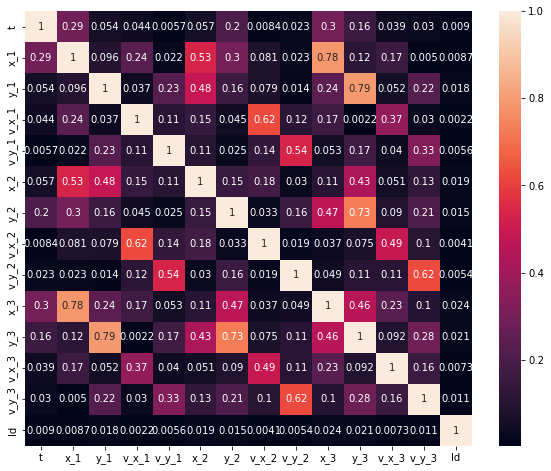

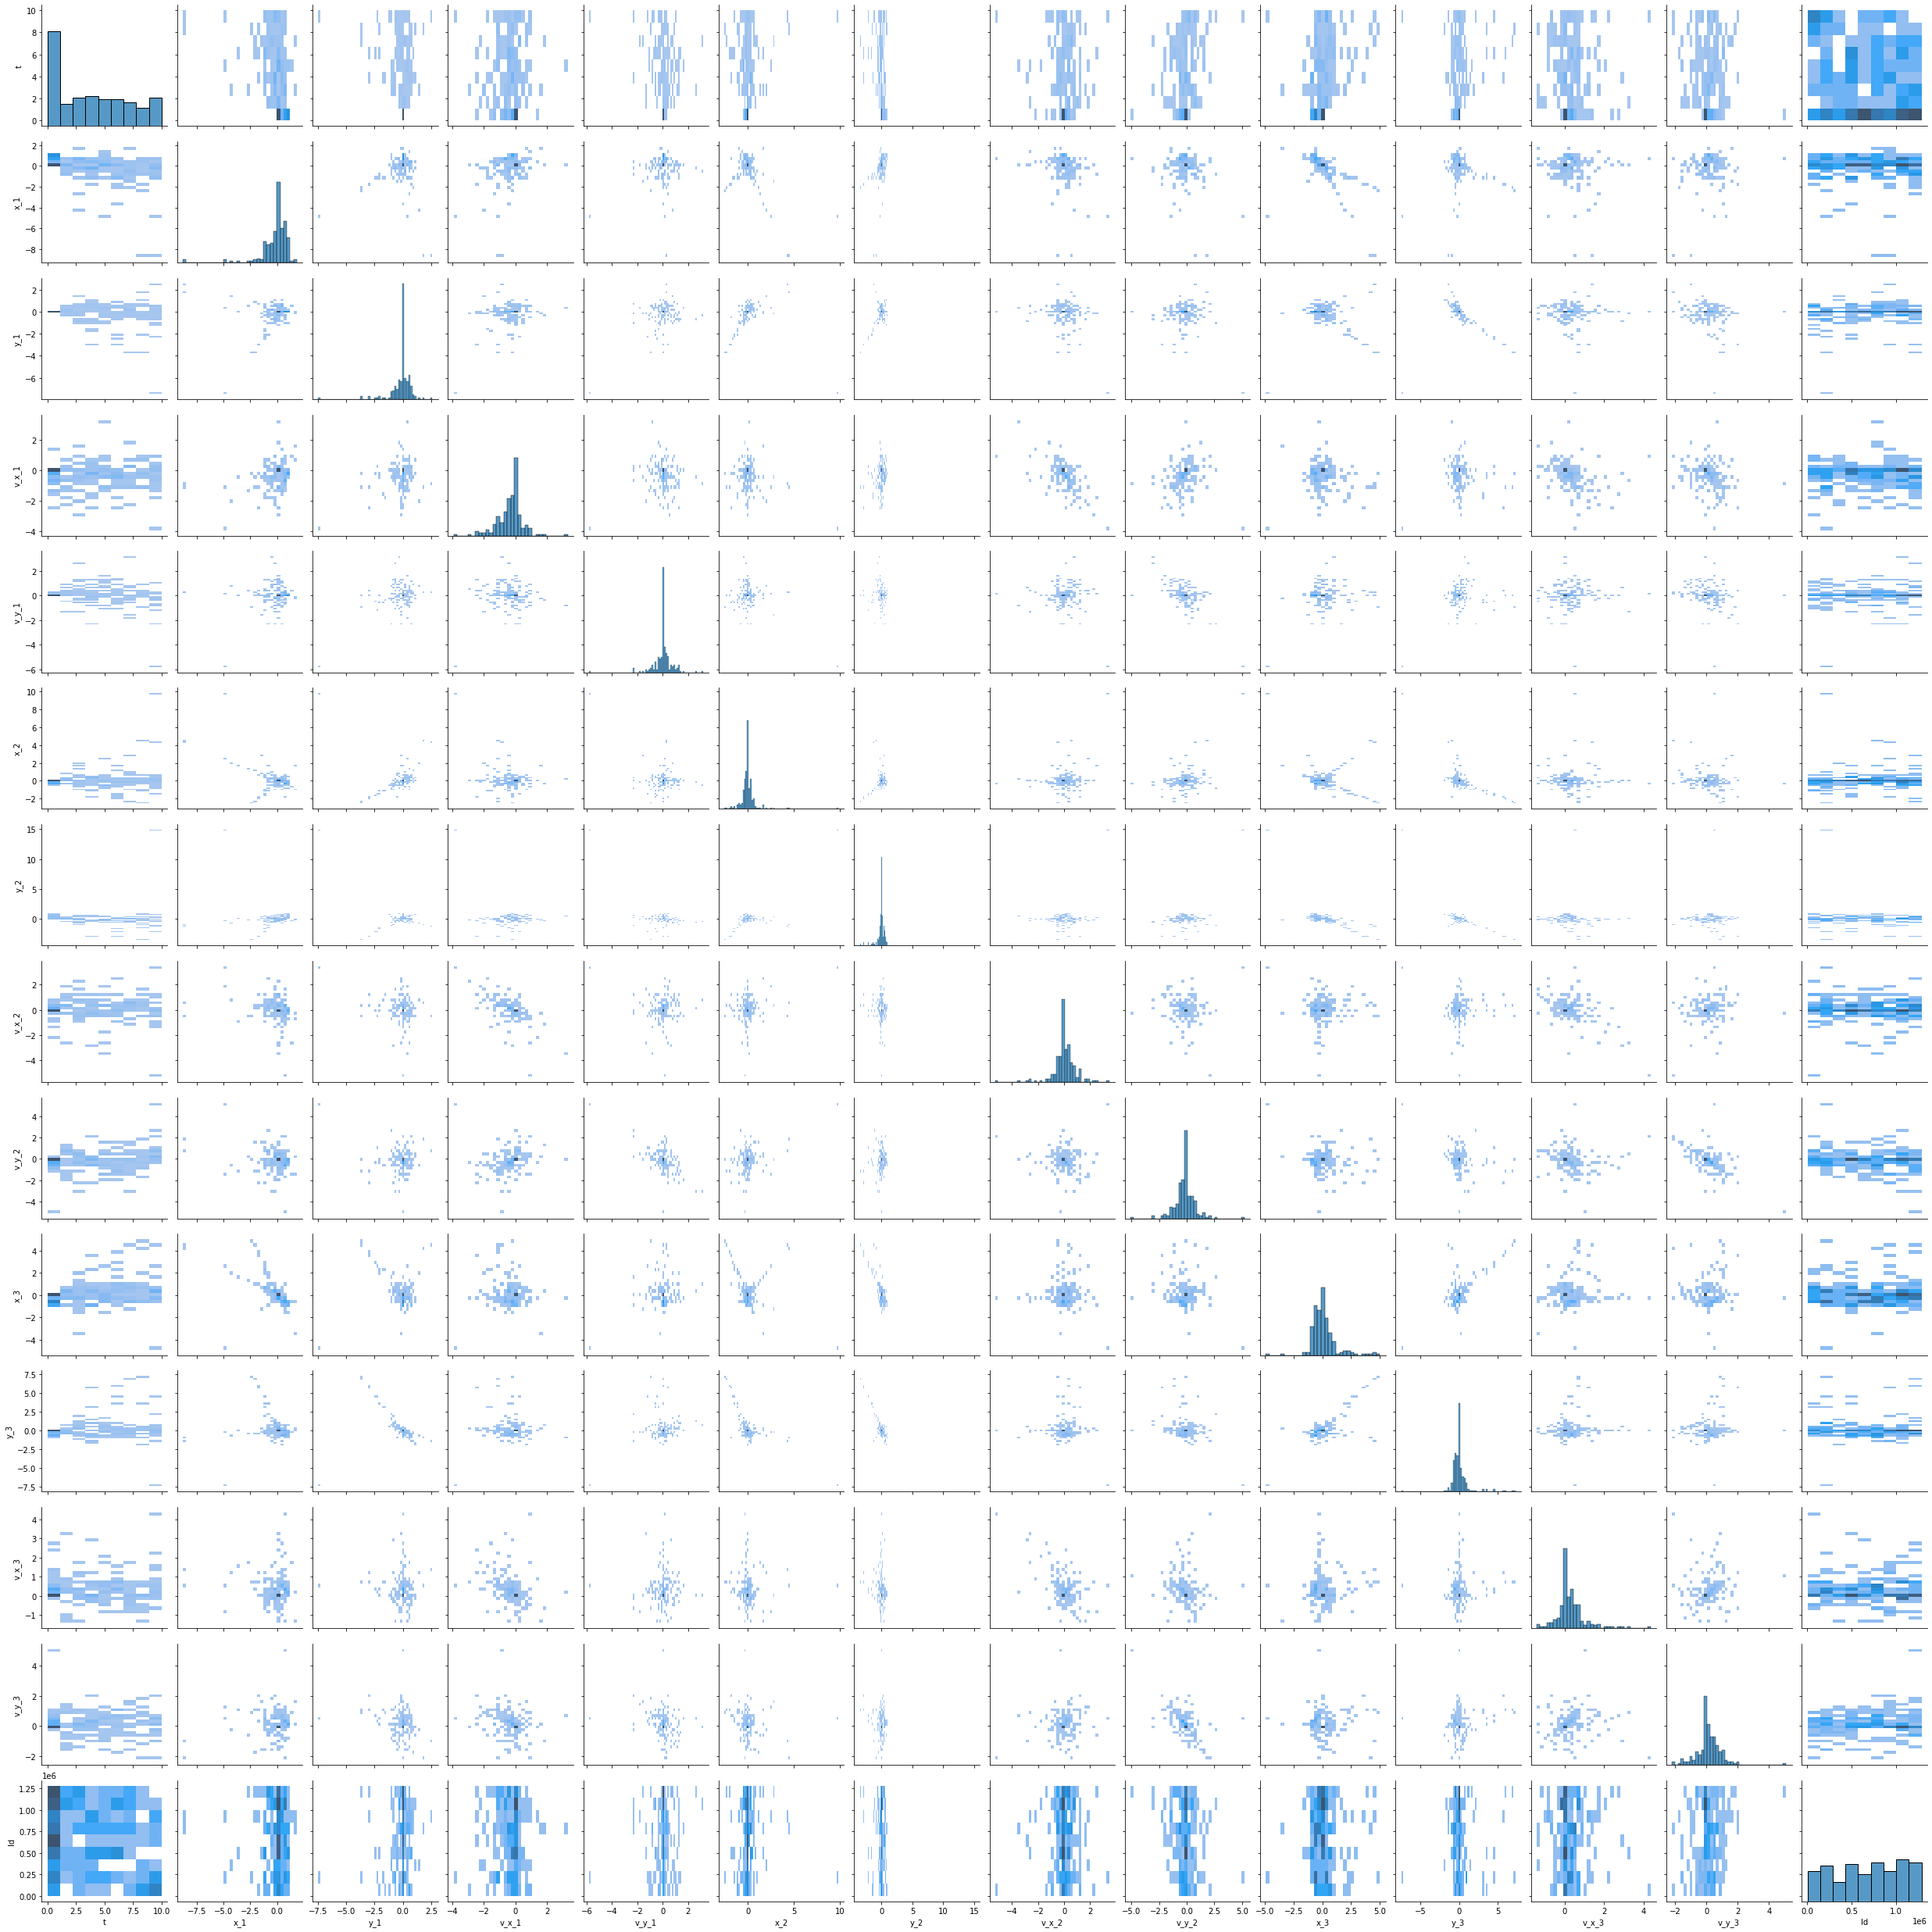

In [51]:
# Evaluate and remove the correlated variables
# Calculate the correlation matrix
correlation_matrix = raw_train_data.corr().abs()  
target_variables = ['x_1', 'x_2','x_3', 'y_1', 'y_2','y_3']
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True)
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')

pairplot = sns.pairplot(raw_train_data.sample(200), kind="hist")
plt.savefig("pairplot.png") 

#Define a threshold for correlation
threshold = 0.7  # Define the threshold for removing correlated variables

# Identify correlated variables
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]  # Get the column name
            if colname not in target_variables:
                to_drop.add(colname)  # Mark the variable for dropping

# Drop the correlated variables
train_data_reduced = raw_train_data.copy()
y_reduced = train_data_reduced[target_variables]
test_data_reduced = test_data[target_variables]
train_data_reduced = raw_train_data.drop(columns=to_drop)



#### Task 3.2 Evaluation of Variable Reduction

InvalidIndexError: (array([200294, 179455,  63452, 105402, 230636,  55021, 187947,   4399,
        45987,  61981, 198362, 146298, 248671, 250428, 124679, 183608,
        98403,  40782, 237375,   6751,  17302, 131336, 136386,  31542,
       169497,  85366,  37645,  62659,  20674, 138037, 227702, 217526,
       187969, 244159,  12755, 123273, 256321,  22847,  43758,  95040,
        38233,  86712,  77575, 182455,  67028,  27217, 223286,  76037,
        99420, 157388, 128315, 163049, 173418, 235833,  29650, 168960,
       206154,  65348, 245815, 168974,  72006, 112453,  61856, 225061,
       133514, 115663, 178233,  77780,  32965, 202212,  82357,   2487,
        29058,  47166, 155098,  16915, 142429, 232468, 248990, 186039,
       155070, 101199, 122916, 119158, 148211, 113365,  88750, 201114,
       167101, 105526, 106753, 168870, 172737, 105218,  23710, 100787,
       148841, 247541,  85021, 122282, 138765, 160575, 228759, 121050,
       141476, 200131, 100298, 198369, 125006, 249834, 225853, 161158,
       211093, 144257, 102057, 147386, 117380,  28311,  53144, 195135,
        62573,  41087,  99927,  81294, 192200, 251999, 149051, 163272,
       203387, 186368,  77096, 255084, 237431, 113602,  47718, 126191,
        34426, 177574,  43943, 145492, 193427,  41273, 126203,  87705,
       223838, 143581,   9169, 126601, 138250,  92910,   8781, 137199,
       202286, 142447, 171376,  61172, 157294,  28062, 169166, 244070,
        61630,  73162, 246217, 154612, 199191,  23743,  38519,  76097,
       169403, 254887, 157444, 177577, 224156,  56158,  29388, 143878,
       225697,  16130, 132081,  30091, 117163, 119383, 106631, 243678,
       116796, 205467, 185041,  35894, 163629, 243657, 143891, 241588,
        99269, 163351,  96156, 161543, 159301, 232425, 199806, 166441,
        67331, 251892,   8268, 104542,  74191,  46778, 166332,   7048,
        88189,  80846, 203305,  36499, 215013, 135803,  26381,  38425,
       252171, 163593, 143748, 108661,  29708,  81793,  39450,   6329,
        24868, 114645,  39257,  43583, 229370,  67201,  17511,  94718,
       212262, 107722, 149774, 211084, 194613,  43839, 158694, 244897,
       221806, 131742, 102156, 241013,  68326,  51051, 166098, 182457,
       170408, 175446, 237613, 127209, 187010, 113213,  83628, 131308,
       122803,  35953,  41574,  14214, 143081, 256905, 140437, 222516,
       240165, 100085,  97970,  26440, 204868,  37694,  24046,  56463,
       149026,  22805, 171654, 185912,  36360, 127963, 188284, 108937,
        54105, 214367, 248254,   8031,  46442, 222203, 242663, 255763,
          719, 193363, 109495,  88316, 208024, 157327, 109029, 102047,
         7249, 244590, 149801, 159630,   7298, 235485,  48519,  48085,
       166832,   6824, 182347, 222589, 154564,  91250, 243782,  18479,
       150538, 134716,  40453, 213806, 160603, 100914, 247016,  29826,
       175460, 164526,  41976, 191500, 108246, 140118, 112213, 246077,
         9336, 211177,  97302,  17422,  76130, 147151, 104978,  79377,
       242602, 215974, 236015, 242870, 149818, 238461,  69375, 192411,
       215724, 161371,  92450, 247473, 138634, 210392,  39972, 171319,
       143658, 120403, 160921, 173082, 188143, 238837,  84381, 142611,
       181833, 156392, 169371, 217123,  24735,  48382, 204551, 122047,
        74635,  35297,  26879, 168673, 142148,  78158, 242473,  18773,
       148319, 112761,    548,  31867,  19159, 118344,  38572, 195315,
       176252, 255979, 118602,  80872,  93017,  80773, 184760, 175252,
       148330,  18858,  19259, 147264,  67790,   6540,  39012, 212358,
        34342,  44873,  66720, 133458, 180540, 158791,  87416, 247905,
       237462, 242394, 201970,  88154,  75128, 242933,  86607, 109662,
       116352,  34138,  57115, 244756,  22706, 129370, 101664, 177549,
        97712, 101069, 143779, 174285,  10177, 112632,  56339, 106551,
       166024, 244124,  43845, 206866,  85930,  62260, 173503,  46378,
         2654,  18299,   1151, 231087,  51933,  25773, 232501,  71185,
       180350, 155397, 232125, 174657, 199585, 132842, 247407, 155977,
       204464, 134291,  36376,  90040, 139240, 141178,  92065, 134833,
       203690,  50788, 239993,   5880, 238453, 235691,  65096,  64389,
        45364,  52918, 120313,  16982, 210871, 237105, 138947,  11270,
       191401,  85833,  64173,   9042,   3982,  40275, 129498, 171363,
        93854, 112766,  42680, 211314, 172008, 216754, 143078, 255352,
       154655, 157612, 181858, 184875]), 0)

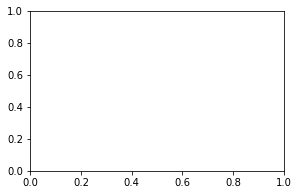

In [52]:

train_data_sampled = train_data_reduced.sample(frac=0.0001, replace=True, random_state=2)

X_train_sampled, X_val_sampled, y_train_sampled, y_val_sampled = train_test_split(
    train_data_reduced, y_reduced, test_size=0.2, random_state=i)
    

pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('regressor', LinearRegression())
])

# Fit the model on the training set
pipeline.fit(X_train_sampled, y_train_sampled)

# Make predictions on the validation set
y_val_pred = pipeline.predict(X_val_sampled)

# Calculate RMSE for the validation set
val_rmse = np.sqrt(mean_squared_error(y_val_sampled, y_val_pred))

plot_y_yhat(y_val_pred, y_val_sampled, plot_title='Test and validation output for reduced model')
        

#### Task 3.3 Adding Variables

In [55]:
# calulate the relative distance between the bodies

train_data_augmented = train_data_reduced.copy()
train_data_augmented['d12'] = math.sqrt((train_data_augmented['x_2']-train_data_augmented['x_1'])**2+(train_data_augmented['y_2']-train_data_augmented['y_1'])**2)
train_data_augmented['d13'] = math.sqrt((train_data_augmented['x_3']-train_data_augmented['x_1'])**2+(train_data_augmented['y_3']-train_data_augmented['y_1'])**2)
train_data_augmented['d23'] = math.sqrt((train_data_augmented['x_3']-train_data_augmented['x_2'])**2+(train_data_augmented['y_3']-train_data_augmented['y_2'])**2)

TypeError: cannot convert the series to <class 'float'>

#### Task 3.4 Evaluation of Variable Augmentation

In [ ]:

train_data_sampled = train_data_augmented.sample(frac=0.0001, replace=True, random_state=2)
target_variables = ['x_1', 'x_2','x_3', 'y_1', 'y_2','y_3']
y_augmented = train_data_reduced[target_variables]
test_data_augmented = test_data[target_variables]
X_train_sampled, X_val_sampled, y_train_sampled, y_val_sampled = train_test_split(
    train_data_augmented, y_augmented, test_size=0.2, random_state=i)
    

pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('regressor', LinearRegression())
])

# Fit the model on the training set
pipeline.fit(X_train_sampled, y_train_sampled)

# Make predictions on the validation set
y_val_pred = pipeline.predict(X_val_sampled)

# Calculate RMSE for the validation set
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

plot_y_yhat(y_val_pred, y_val_sampled, plot_title='Test and validation output for augmented model')
y_val_pred.to_csv('augmented_polynomial_submission.csv', index=False)
        

In [ ]:
### TASK 4: Nonparamentric Model — the k-Nearest Neighbors Regressor
#### Task 4.2: Evaluation

# Auxiliar Functions

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import random

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1, 15)):
    '''
    Validates a polynomial regression model with different degrees of the polynomial, evaluates the training 
    and validation errors, and optionally limits the number of polynomial features used.
    
    Parameters:
    - X_train: Training set features (numpy array or pandas DataFrame).
    - y_train: Training set target values (numpy array or pandas DataFrame).
    - X_val: Validation set features (numpy array or pandas DataFrame).
    - y_val: Validation set target values (numpy array or pandas DataFrame).
    - regressor: A regression model instance. If None, LinearRegression is used as default.
    - degrees: Range of polynomial degrees to validate (default: range(1, 15)).
    
    Returns:
    - best_pipeline: The pipeline model that produced the lowest validation RMSE.
    - best_rmse: The lowest RMSE value on the validation set.
    '''
    results = []
    best_rmse = float('inf')
    best_pipeline = None  # Initialize to None

    for degree in degrees:
        # Create a pipeline for Polynomial Regression
        print(f"Testing degree {degree}...")
        pipeline = Pipeline([
            ('poly_features', PolynomialFeatures(degree=degree)),
            ('regressor', regressor if regressor else LinearRegression())
        ])
        
        # Fit the model on the training set
        pipeline.fit(X_train, y_train)
        
        # Make predictions on the validation set
        y_val_pred = pipeline.predict(X_val)
        
        # Calculate RMSE for the validation set
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        # Store the best model if this degree yields a lower validation RMSE
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_pipeline = pipeline

        print(f"Degree {degree}: Validation RMSE = {val_rmse:.4f}")
        results.append({
            'Degree': degree,
            'Validation RMSE': val_rmse
        })
        
    # Optional: Save the results to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv('polynomial_submission.csv', index=False)
    print("Results saved to polynomial_submission.csv")
    
    return best_pipeline, best_rmse

In [ ]:
 def validate_knn_regression(X_train, y_train, X_val, y_val, X_test, y_test, k=range(1, 2)):
        """
        Validate a kNN regression model over a range of k values.
        
        Parameters:
        - X_train: Training features (DataFrame or array-like)
        - y_train: Training target values (DataFrame or array-like)
        - X_val: Validation features (DataFrame or array-like)
        - y_val: Validation target values (DataFrame or array-like)
        - X_test: Test features (DataFrame or array-like)
        - y_test: Test target values (DataFrame or array-like)
        - k: Range of k values to evaluate (default: range(1, 15))
        
        Returns:
        - results_df: DataFrame with k values, MSE, R² scores, training time, and inference time
        """
        results = []  # To store results for each k

        for k_value in k:
            # Initialize the KNN regressor
            knn_model = KNeighborsRegressor(n_neighbors=k_value, algorithm='ball_tree', n_jobs=-1)

            # Measure training time
            start_time = time.time()
            knn_model.fit(X_train, y_train)
            training_time = time.time() - start_time

            # Measure inference time
            start_time = time.time()
            y_val_pred = knn_model.predict(X_val)
            inference_time_val = time.time() - start_time

            # Calculate evaluation metrics for validation set
            val_mse = mean_squared_error(y_val, y_val_pred)
            val_rmse = np.sqrt(val_mse)
            val_r2 = r2_score(y_val, y_val_pred)

            # Measure inference time on the test set
            start_time = time.time()
            y_test_pred = knn_model.predict(X_test)
            inference_time_test = time.time() - start_time

            # Calculate evaluation metrics for the test set
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(test_mse)
            test_r2 = r2_score(y_test, y_test_pred)
            
            # Store results
            results.append({
                'k': k_value,
                'Val MSE': val_mse,
                'Val RMSE': val_rmse,
                'Val R²': val_r2,
                'Training Time (s)': training_time,
                'Inference Time Val (s)': inference_time_val,
                'Test MSE': test_mse,
                'Test RMSE': test_rmse,
                'Test R²': test_r2,
                'Inference Time Test (s)': inference_time_test
            })
        results_df = pd.DataFrame(results)
        results_df.to_csv(knn_results.csv, index=False)
        print(f"Rsultados exportados para {knn_results.csv}")
        print(f"Melhor k: {best_k} com Validation RMSE = {best_rmse_val:.4f} e Test RMSE = {best_rmse_test:.4f}")
        return results_df
    
    knn_results = validate_knn_regression(X_train, y_train, X_val, y_val, X_test, y_test, k=range(1, 2))
    print("\nResults of kNN Regression Validation:")
    print(knn_results)

In [ ]:
def plot_y_yhat(y_val,y_pred, plot_title = "plot"):
    ''' 
    designed to create a scatter plot comparing the true versus predicted values for a multi-dimensional regression problem, and then 
    save the plot as a PDF. This is useful for visualizing how well the model predictions align with the true values.
    Parameters:
    - y_val: Validation set target values (numpy array or pandas DataFrame).
    - y_pred: Predicted values.
    - plot_title: A string representing the title of the plot.

    Returns: 
     - A PDF containing a scatter plot comparing the true versus predicted values for a multi-dimensional regression problem
    '''
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val),MAX, replace=False)
    else:
        idx = np.arange(len(y_val))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_val[idx,i])
        x1 = np.max(y_val[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_val[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()